# NVAR Temporal Subsampling

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
import seaborn as sns

from sqgtools import XSQGTurb, SpectrumPlotter

In [2]:
sys.path.append("..")
from rcgfd import BigPlot

In [36]:
plt.style.use("./rc-gfd.mplstyle")

In [4]:
fig_dir = "../figures"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [10]:
def read_aws_result(n_lag, n_sub, n_overlap=1):
    """Read these in from AWS directory moved to GCP ... thanks RDHPCS
    """
    
    dt0 = 300
    delta_t = n_sub * delta_t0
    fname = '/contrib/Tim.Smith/qgrc-teachers/sqg/resolution/aws-resolution-results/nvar-temporal-sampling-064n/'
    fname += f'validation-{n_samples:03d}samples/{delta_t:04d}dt-lag{n_lag:02d}-nb{n_overlap:02d}/results.zarr/'
    
    tmp = xr.open_zarr(fname, chunks={"x":16, "y":16})
    tmp = tmp.rename({"truth":"pp"}).rename({"prediction":"truth"}).rename({"pp":"prediction"})
    tmp = tmp.expand_dims({'n_sub': [n_sub], 'n_lag': [n_lag]})
    return tmp
    

In [11]:
n_samples = 50

dslist0=[] 
for n_lag in [0,1,2,3]:
    dslist = []
    for n_sub in [1,2,4,8,16]:
        xds = read_aws_result(n_lag, n_sub)
        dslist.append(xds)

    dslist0.append(xr.concat(dslist, dim='n_sub'))
ds = xr.concat(dslist0, dim='n_lag')
ds.attrs['keep_spinup'] = 'False'
ds.attrs['spinup_steps_predict'] = 0

In [12]:
ds["truth"] = ds["truth"].isel(n_sub=0)
ds["error"] = ds["prediction"] - ds["truth"]

In [13]:
ds["absolute_error"] = np.abs(ds["error"])

Grab one sample for some plotting

In [14]:
xds = ds.sel(n_lag=1, n_sub=[1,4,16], sample=49)

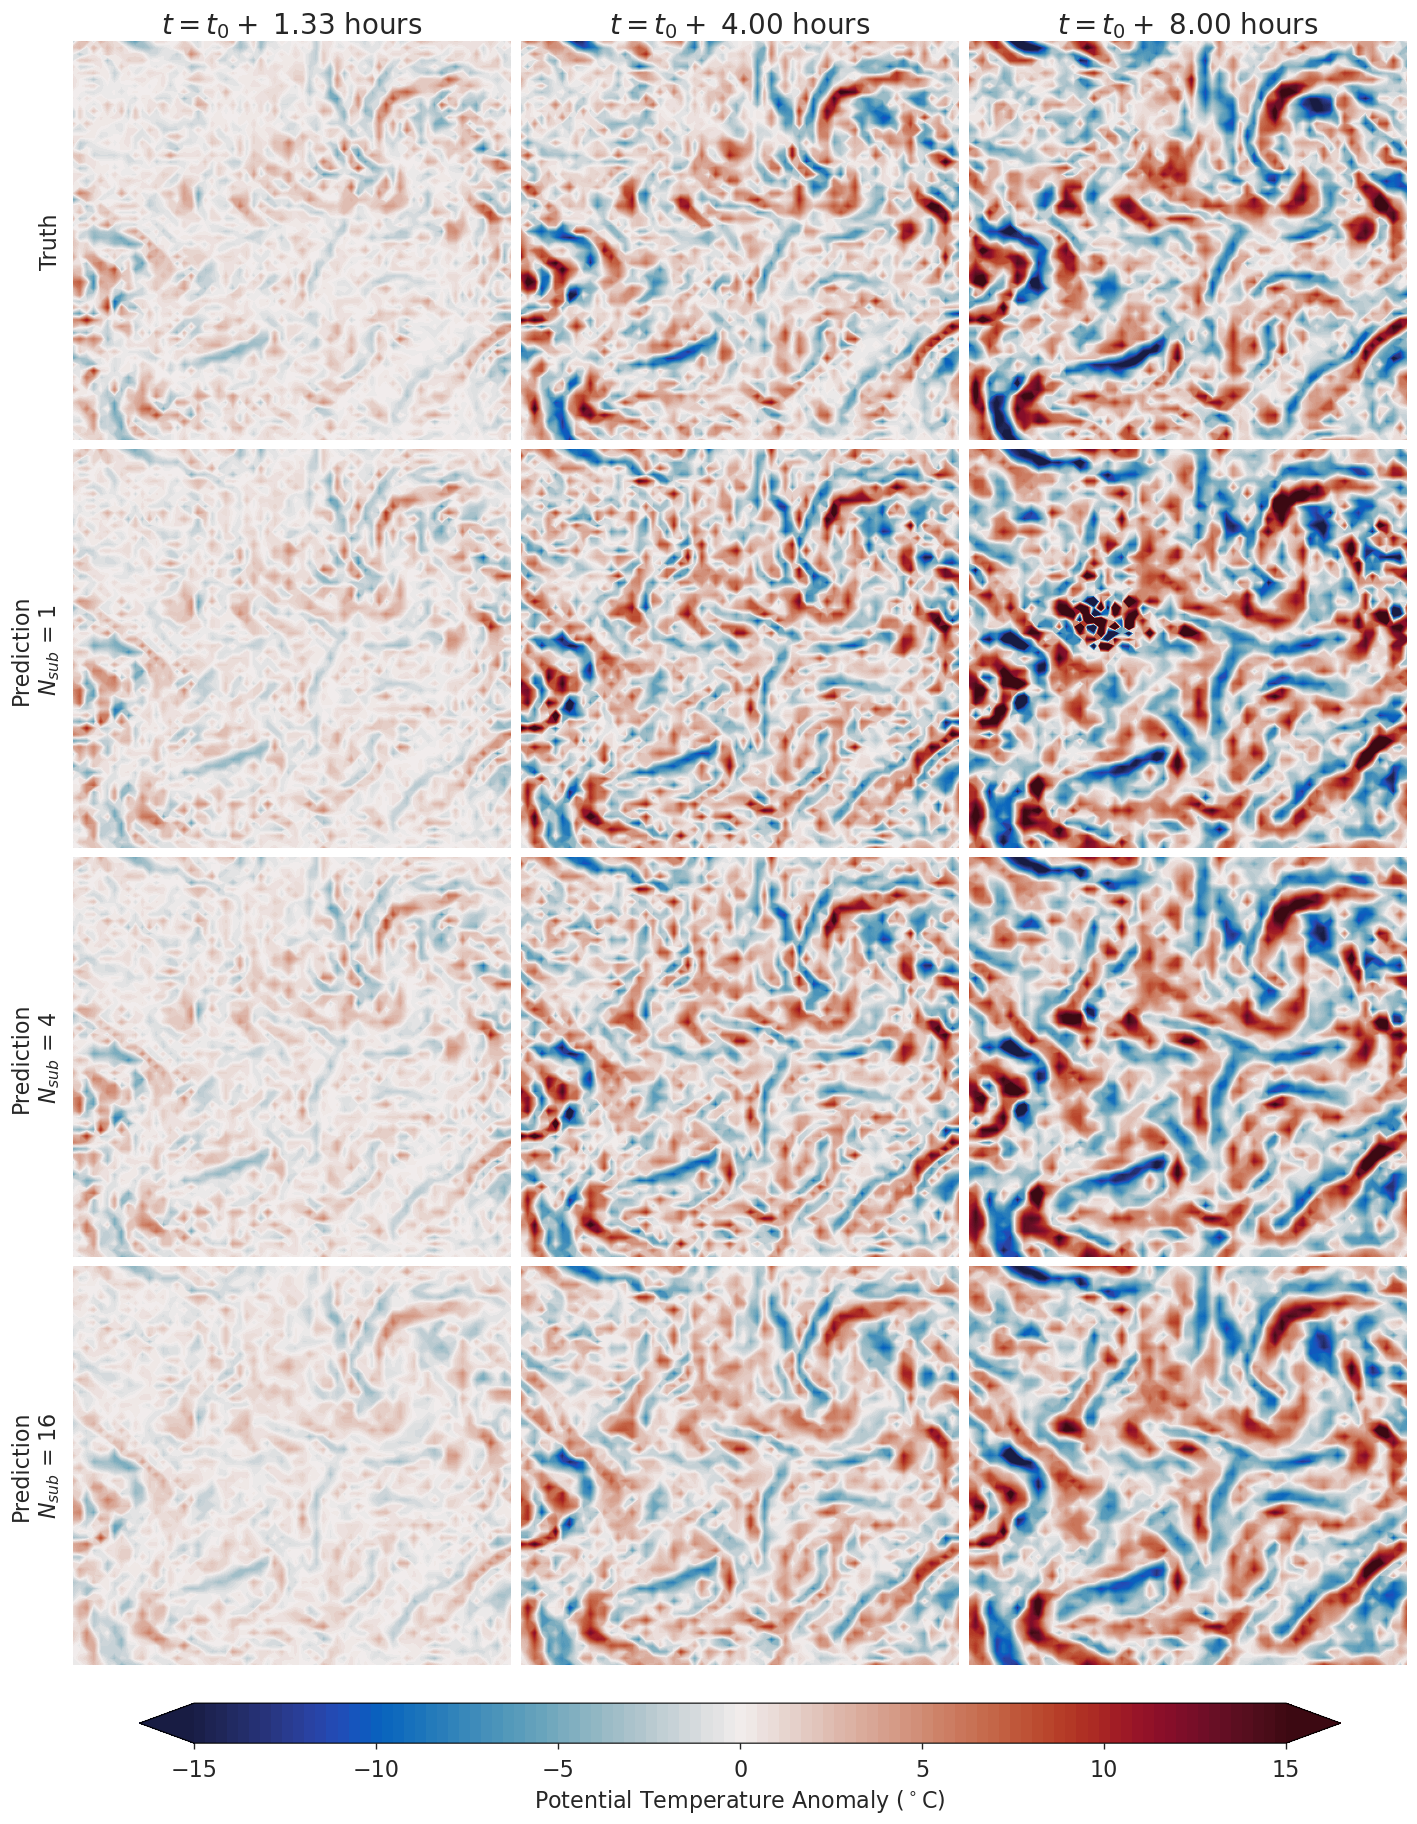

In [15]:
bp = BigPlot()
fig, axs = bp(xds)
fig.savefig(f"{fig_dir}/nvar_big_plot.jpg", dpi=300, bbox_inches="tight")

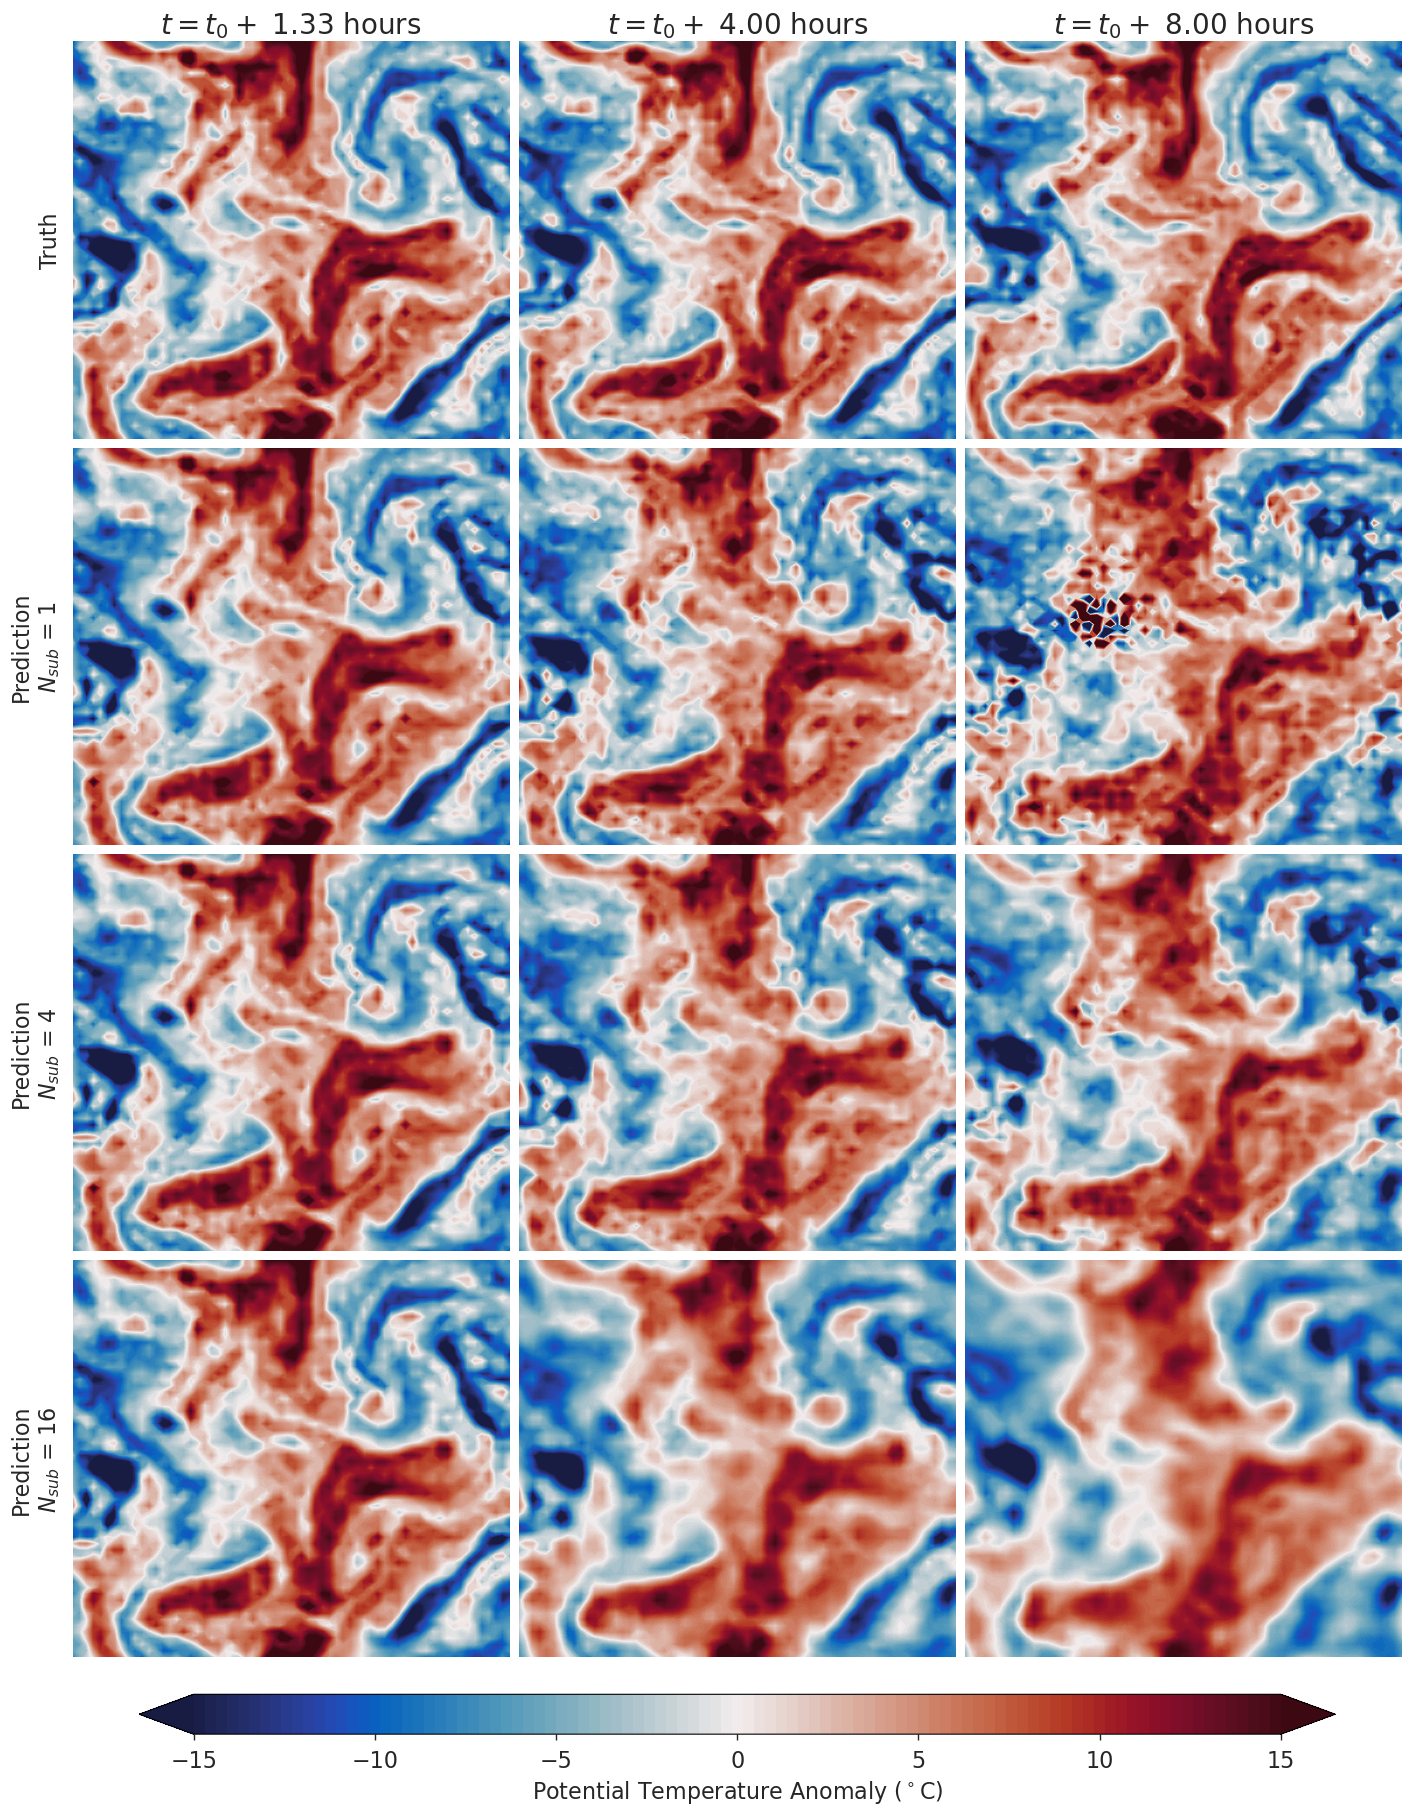

In [16]:
bp = BigPlot(diff_t0=False)
fig, axs = bp(xds)

In [17]:
ep = BigPlot(prediction="absolute_error",
             cbar_label=r"Absolute Error ($^\circ C$)",
             cmap="viridis",
             plot_truth=False,
             vmax=10,
             vmin=0,
             subplot_kw={
                 "figsize":(14,14),
                 "constrained_layout": True,
             }
            )

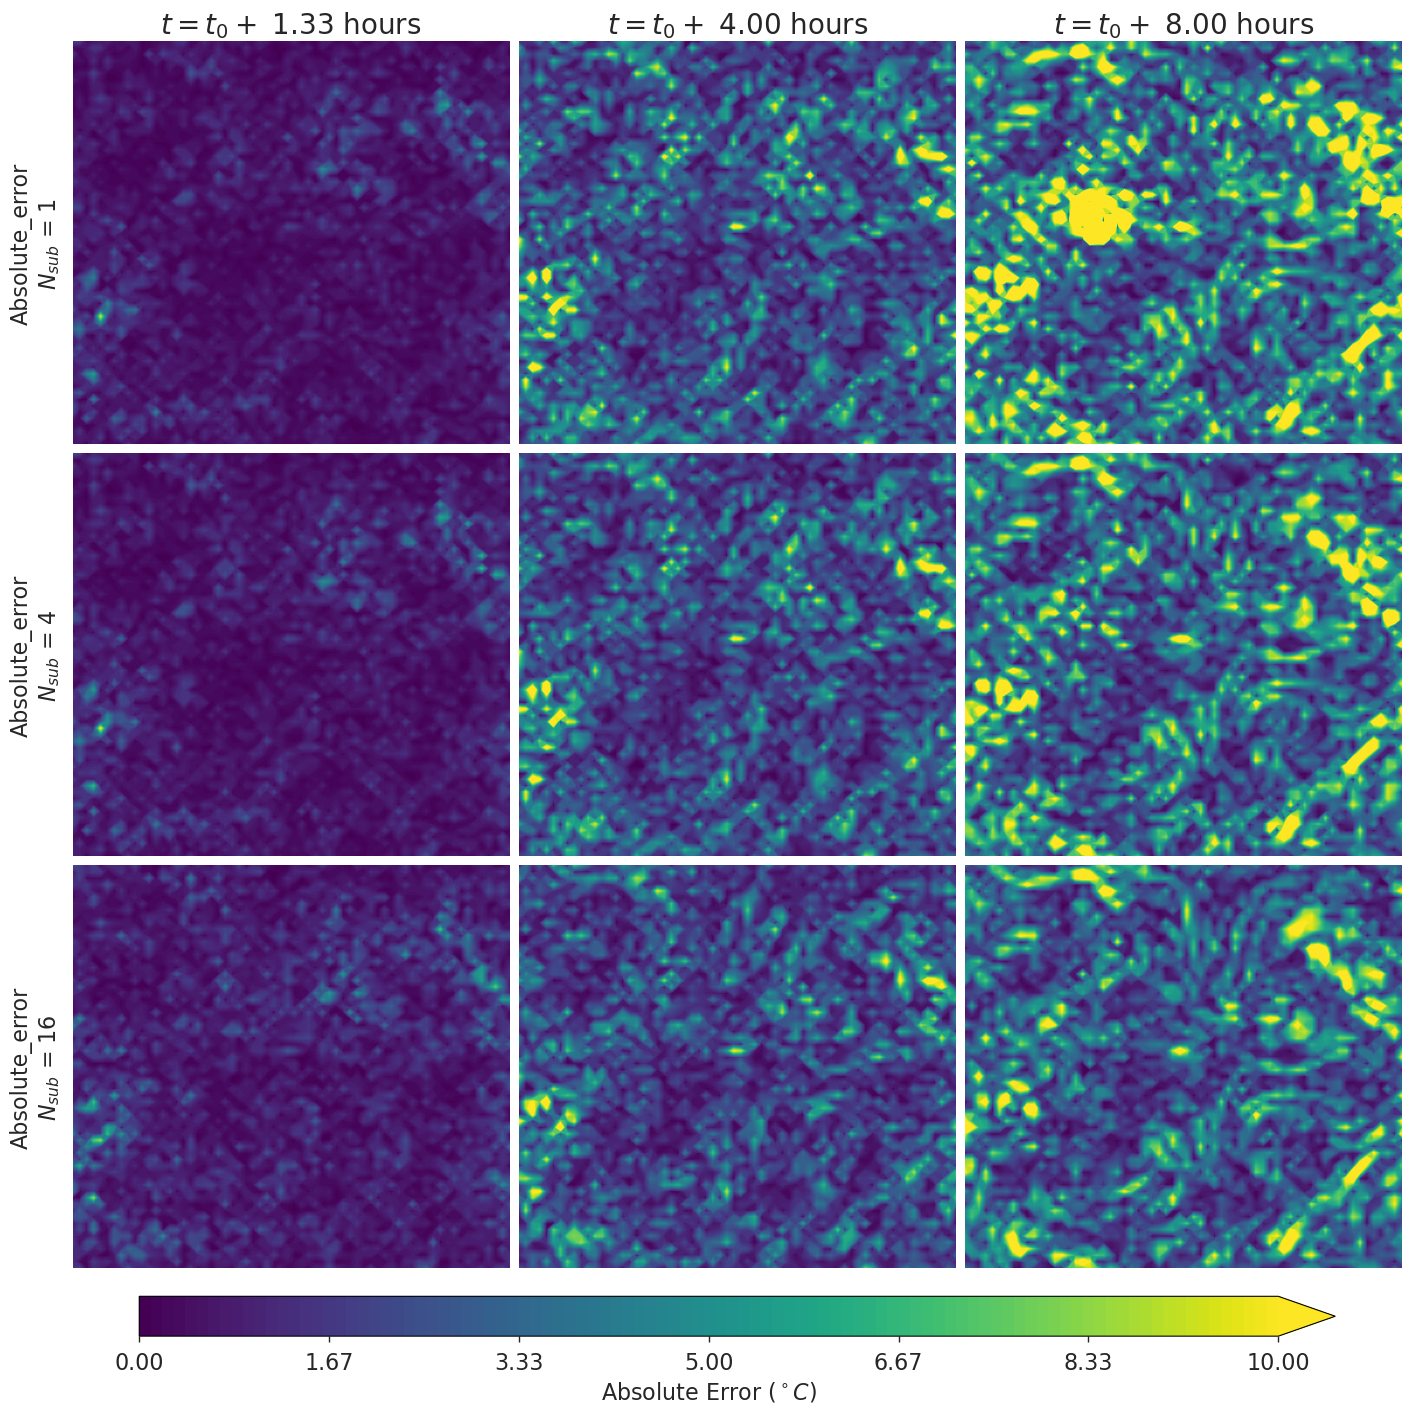

In [18]:
fig, axs = ep(xds)

## Histograms

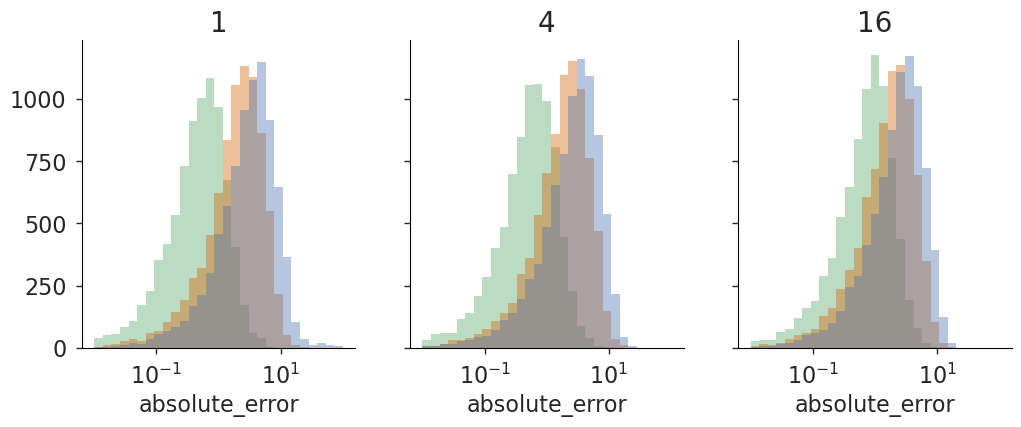

In [19]:
fig, axs = plt.subplots(1,3, figsize=(12,4), sharey=True)

#bins = np.linspace(-50,50,30)
bins = np.logspace(-2, 2, 30)

for n_sub, ax in zip([1,4,16], axs):
    for t in bp.time:
        plotme = xds.absolute_error.sel(n_sub=n_sub).sel(time=t)
        plotme.plot.hist(bins=bins, alpha=.4, ax=ax);
    ax.set(title=n_sub)
        
    ax.set(xscale='log')

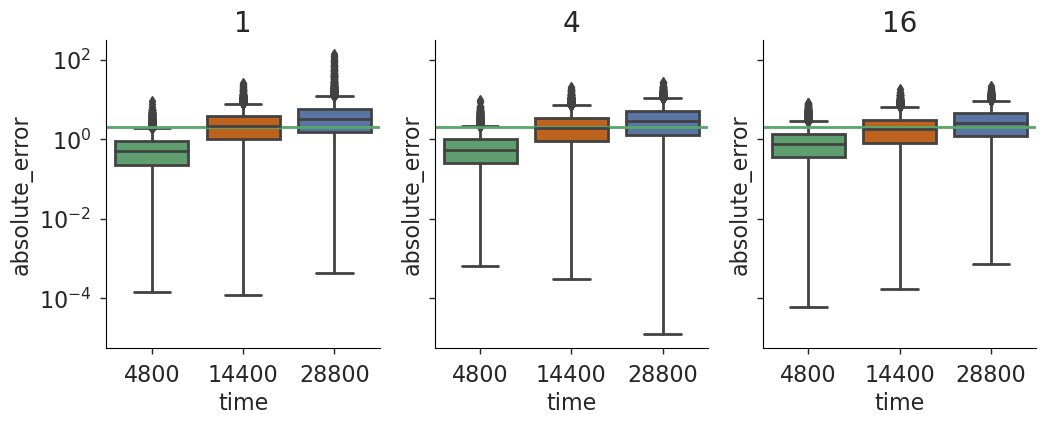

In [20]:
fig, axs = plt.subplots(1,3, figsize=(12,4), sharey=True)

#bins = np.linspace(-50,50,30)
bins = np.logspace(-2, 2, 30)

for n_sub, ax in zip([1,4,16], axs):
    plotme = xds.absolute_error.sel(n_sub=n_sub).sel(time=bp.time)
    sns.boxplot(
        data=plotme.to_dataframe().reset_index(),
        x="time",
        y="absolute_error",
        ax=ax,
    )
        #plotme.plot.hist(bins=bins, alpha=.4, ax=ax);
    ax.set(title=n_sub, yscale='log')
    
    ax.axhline(y=2)

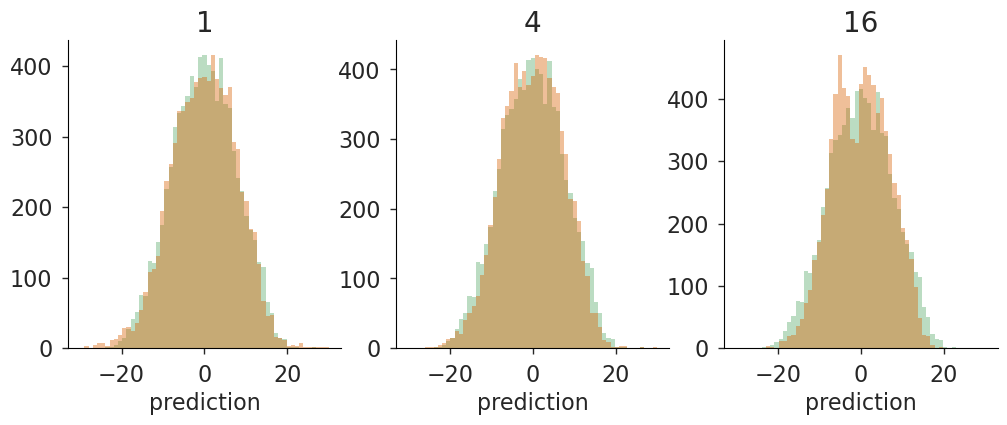

In [21]:
fig, axs = plt.subplots(1,3, figsize=(12,4))

bins = np.linspace(-30,30,60)
#bins = np.logspace(-2, 2, 30)

for n_sub, ax in zip([1,4,16], axs):
    t = bp.time[-1]
    for key in ["truth", "prediction"]:
        plotme = xds[key].sel(time=t)
        if "truth" not in key:
            plotme = plotme.sel(n_sub=n_sub)
        plotme.plot.hist(bins=bins, alpha=.4, ax=ax);
    ax.set(title=n_sub)
        
    #ax.set(xscale='log')

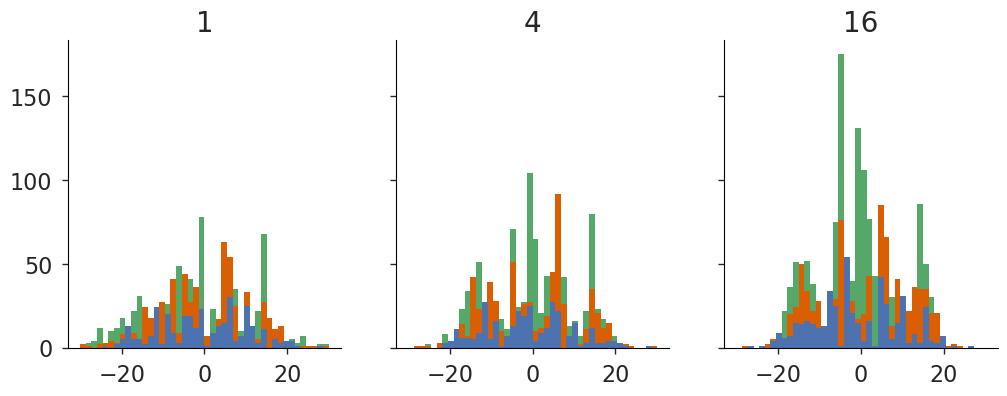

In [22]:
fig, axs = plt.subplots(1,3, figsize=(12,4), sharey=True)

bins = np.linspace(-30,30,45)
#bins = np.logspace(-2, 2, 30)

for n_sub, ax in zip([1,4,16], axs):
    for t in bp.time[::-1]:
        bdict = {}
        for key in ["truth", "prediction"]:
            plotme = xds[key].sel(time=t)
            if "truth" not in key:
                plotme = plotme.sel(n_sub=n_sub)
            bdict[key], *_ = np.histogram(plotme, bins=bins);
            bc = .5*bins[:-1] + .5*bins[1:]
            
        eb = bdict["prediction"] - bdict["truth"]
        eb = np.abs(eb)
        ax.bar(bc, eb, width=1.4)
    ax.set(title=n_sub)

## Spectra

In [24]:
time = np.arange(0,ds.time.max().values+1, 4800)
xds = ds.sel(n_lag=[1,2,3], n_sub=[1,4,16], time=bp.time)

In [25]:
xsqg = XSQGTurb()
ktrue = xsqg.calc_kespec1d(xds["truth"].load())
kpred = xsqg.calc_kespec1d(xds["prediction"].load())

In [26]:
kerr = kpred - ktrue
relerr = np.abs(kerr/ktrue)

In [30]:
sp = SpectrumPlotter(n_colors=7)
colors = sp.colors[::3]

In [68]:
from matplotlib.ticker import LogLocator

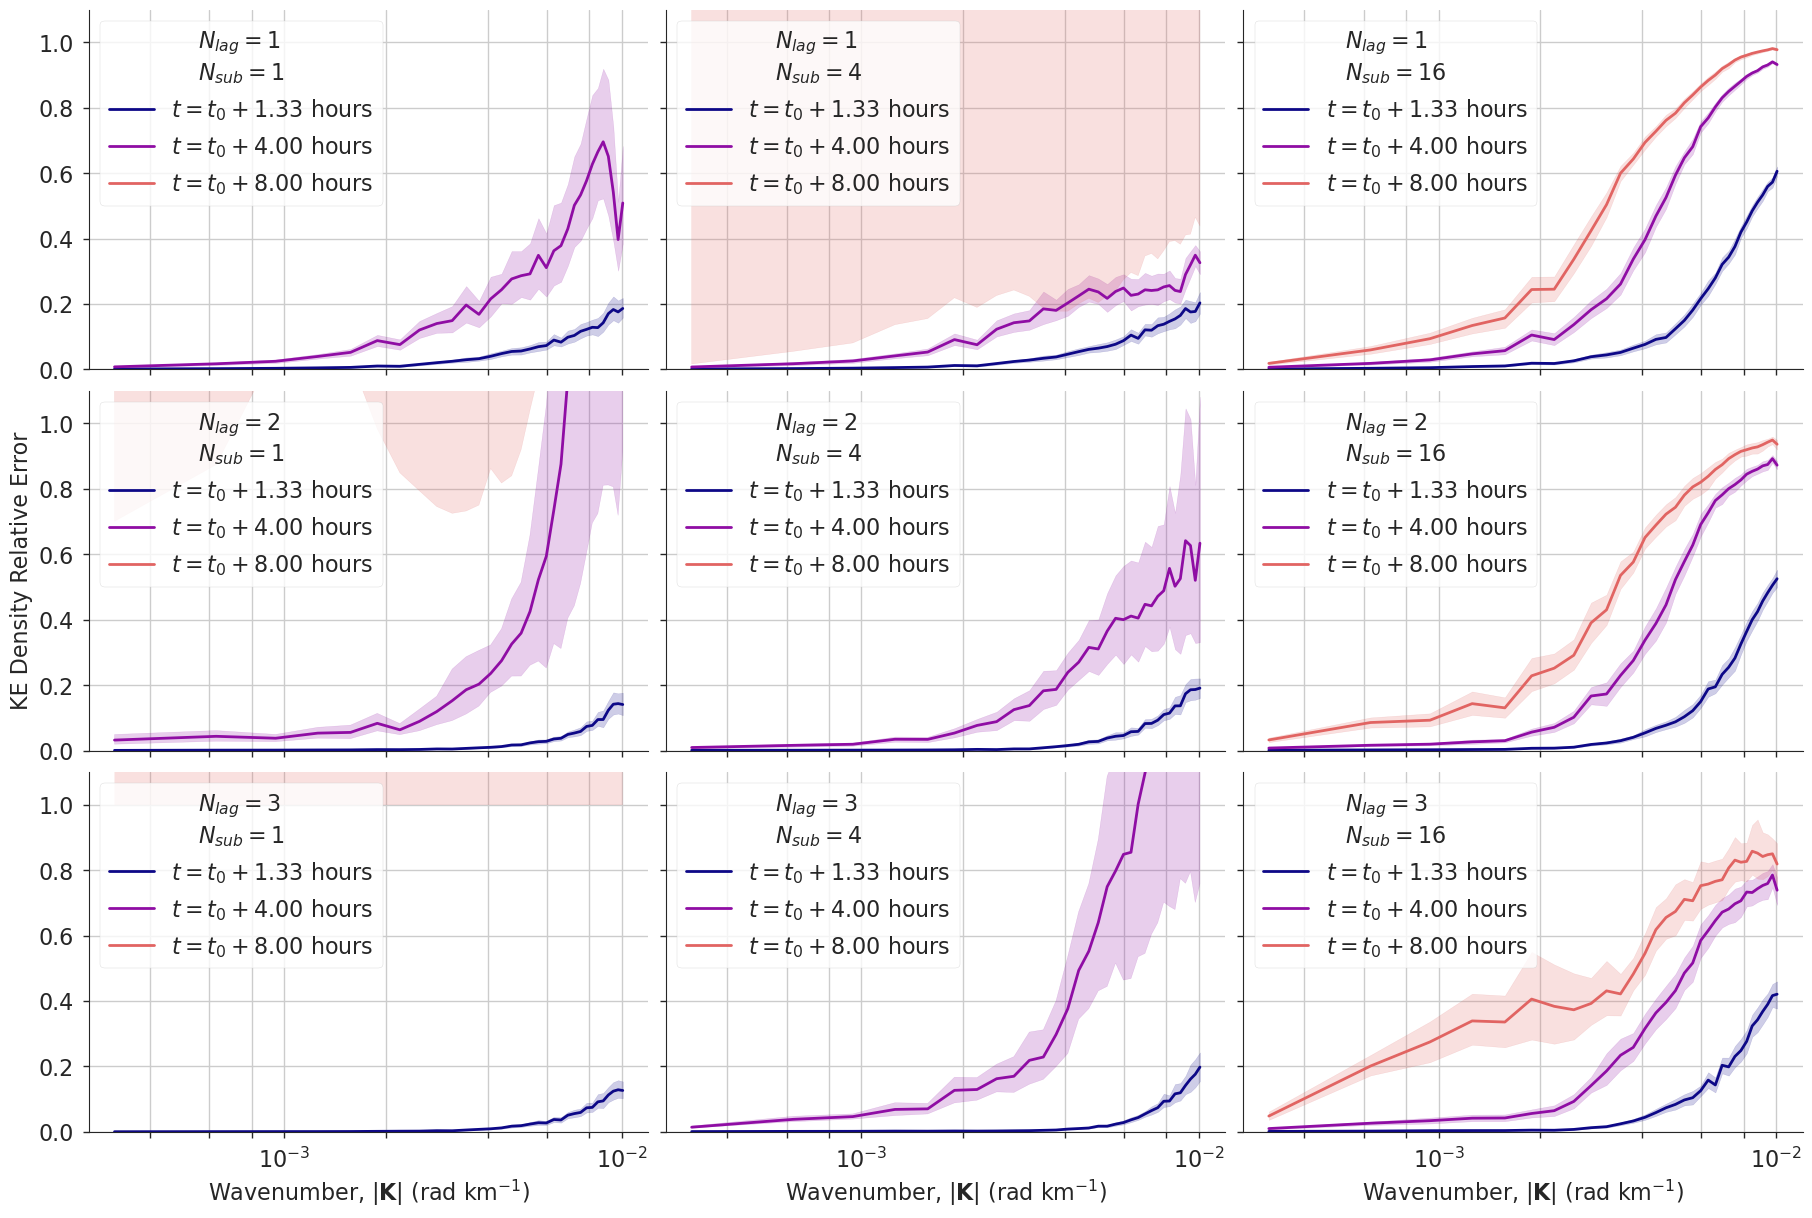

In [71]:
with plt.rc_context({"xtick.minor.size":4,"xtick.minor.width":1}):
    fig, axs = plt.subplots(3, 3, figsize=(18,12), constrained_layout=True, sharex=True, sharey=True)

for n_lag, axr in zip(xds.n_lag, axs):
    for n_sub, ax in zip(xds.n_sub, axr):
        for t, c in zip(
            relerr.time,
            colors,
        ):
            plotme = relerr.sel(n_sub=n_sub,n_lag=n_lag,time=t)
            plotme=plotme.to_dataframe()
            sns.lineplot(
                data=plotme,
                x="k1d",
                y="KE Density",
                color=c,
                ax=ax,
                label="$t = t_0 + %1.2f$ hours" % float(t/3600),
            )
        
        ax.legend(
            title=r"$N_{lag} = %d$%s$N_{sub} = %d$" % (n_lag,"\n", n_sub),
            loc="upper left",
            frameon=True,
        )
        ax.set(
            xscale="log",
            ylim=[0,1.1],
            ylabel="",
            xlabel="",
        )
        ax.xaxis.set_minor_locator(LogLocator(numticks=999, subs=(.2, .4, .6, .8)))
        ax.grid(True, which="both")
            
for ax in axs[-1,:]:
    ax.set(
        xlabel=r"Wavenumber, $|\mathbf{K}|$ (rad km$^{-1}$)",
    )
       
axs[1,0].set(ylabel="KE Density Relative Error")
fig.savefig(f"{fig_dir}/nvar_big_ke_relerr.pdf", bbox_inches="tight")